## Imports

In [394]:
import pandas as pd
import glob
import datasets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [364]:
wiki_data = pd.read_csv("../../data/wikidata/wikidata-property-list.csv")
wiki_data = wiki_data[["Title", "ID", "Datatype", "Description"]]
wiki_data

,Title,ID,Datatype,Description
0,head of government,6,item,"head of the executive power of a town, city, m..."
1,brother,7,item,subject has the object as their brother
2,sister,9,item,subject has the object as their sister (female...
3,video,10,Commons file,relevant video
4,highway marker,14,Commons file,graphic representing the highway
...,...,...,...,...
1193,catholic.ru ID,1453,string,identifier on the site catholic.ru
1194,legal form,1454,item,legal form of an organization
1195,list of works,1455,item,link to the article with the works of a person
1196,list of monuments,1456,item,link to the list of heritage monuments in the ...


In [365]:
list(wiki_data[wiki_data["ID"] == 176]["Title"])[0]

'manufacturer'

In [366]:
code_to_lang_dict = {
    "bg": "Bulgarian",
    "ca": "Catalan",
    "cs": "Czech",
    "da": "Danish",
    "de": "German",
    "en": "English",
    "es": "Spanish",
    "fr": "French",
    "hr": "Croatian",
    "hu": "Hungarian",
    "it": "Italian",
    "nl": "Dutch",
    "pl": "Polish",
    "pt": "Portuguese",
    "ro": "Romanian",
    "ru": "Russian",
    "sl": "Slovenian",
    "sr": "Serbian",
    "sv": "Swedish",
    "uk": "Ukrainian",
}

In [367]:
lang_to_code_dict = {v: k for k, v in code_to_lang_dict.items()}
languages = list(code_to_lang_dict.values())

In [496]:
language_families = {
    "Slavic": [
        "Bulgarian",
        "Czech",
        "Croatian",
        "Polish",
        "Russian",
        "Slovenian",
        "Serbian",
        "Ukrainian",
    ],
    "Romance": ["Catalan", "Italian", "Portuguese", "Romanian", "Spanish", "French"],
    "Germanic": ["Danish", "German", "Dutch", "English", "Swedish"],
    "Hungarian": ["Hungarian"],
}

In [369]:
results_dict = {}
results_dict["language"] = []
results_dict["relation"] = []
results_dict["percentage change"] = []
results_dict["new ratio of rows"] = []
results_dict["old ratio of rows"] = []

hf_df = datasets.load_dataset("CalibraGPT/Fact-Completion")
file_names = glob.glob("../../data/result_logs/llama-30b/error-analysis/*.csv")

# confirm grabbing data correctly against LLaMa figure
# uncomment print statement at end of for loop to see
results_dfs = []
count = 0
for file in file_names:
    language = file.split(".csv")[0].split("-")[-1].capitalize()
    error_df = pd.read_csv(file)
    full_hf_df = hf_df[file.split(".csv")[0].split("-")[-1].capitalize()]
    full_hf_df = full_hf_df.to_pandas()
    print(
        f"for {language} we got {error_df.shape[0]} wrong out of {full_hf_df.shape[0]}"
    )
    # print(error_df.head())
    # print(full_hf_df.head())
    # stem is in both
    # dataset id is in both
    # to see if the model got something wrong, see if the dataset id in the full df is in the error
    error_ids = list(error_df["dataset_id"])
    correct = []
    counts = []
    relation_names = []
    for row in full_hf_df.iterrows():
        # track counts
        count += 1
        counts.append(count)
        # track errors
        correct.append(False) if row[1]["dataset_id"] in error_ids else correct.append(
            True
        )
        # track relation titles
        relation_id = int(row[1].relation[1:])
        relation_title = list(wiki_data[wiki_data["ID"] == relation_id]["Title"])[0]
        relation_names.append(relation_title)

    # append result to full df
    full_hf_df["correct"] = correct
    # append language to full df
    full_hf_df["language"] = [language] * full_hf_df.shape[0]
    # append language code to full df
    lang_code = lang_to_code_dict[language]
    full_hf_df["lang_code"] = [lang_code] * full_hf_df.shape[0]
    # append relation title to full df
    full_hf_df["relation_title"] = relation_names
    # also append an arbitrary id to have unique val for each row
    full_hf_df["analysis_id"] = counts

    results_dfs.append(full_hf_df)

results_df = pd.concat(results_dfs)
languages = results_df.language.unique()

assert results_df.shape[0] == count

Found cached dataset parquet (/Users/ashbhat/.cache/huggingface/datasets/CalibraGPT___parquet/CalibraGPT--Fact-Completion-24a24a1e4bf6e4a8/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/20 [00:00<?, ?it/s]

for Serbian we got 2170 wrong out of 5426
for Ukrainian we got 2138 wrong out of 7918
for Dutch we got 3309 wrong out of 22590
for Swedish we got 3440 wrong out of 21576
for Hungarian we got 1128 wrong out of 4650
for Catalan we got 3021 wrong out of 18898
for Polish we got 2137 wrong out of 9484
for Russian we got 996 wrong out of 3289
for Bulgarian we got 5658 wrong out of 20577
for Slovenian we got 1890 wrong out of 7873
for English we got 2782 wrong out of 26254
for German we got 2323 wrong out of 16287
for Portuguese we got 3719 wrong out of 22974
for Czech we got 2080 wrong out of 9427
for Spanish we got 3430 wrong out of 18786
for Croatian we got 1715 wrong out of 7358
for Danish we got 4255 wrong out of 23365
for French we got 2910 wrong out of 18395
for Italian we got 3192 wrong out of 20448
for Romanian we got 3035 wrong out of 17568


## Explore Data

In [370]:
results_df.head()

,dataset_id,stem,true,false,relation,subject,object,correct,language,lang_code,relation_title,analysis_id
0,calinet_8922,Приус производи,Тоиота,Хонда,P176,Приус,Тоиота,True,Serbian,sr,manufacturer,1
1,rome_5025,Сундар Пицхаи ради за,Гоогле,Аппле,P108,Сундар Пицхаи,Гоогле,False,Serbian,sr,employer,2
2,rome_21333,"Главни град Народне Републике Кине,",Пекинг,Кабул,P36,Народна Република Кина,Пекинг,True,Serbian,sr,capital,3
3,rome_8738,У Синт Мартену разумеју,холандски,дански,P37,Синт Маартен,холандски,True,Serbian,sr,official language,4
4,rome_8783,Хаас Хоусе се налази у месту,Беч,Алберта,P131,Хаас Хоусе,Беч,True,Serbian,sr,is in the administrative territorial entity,5


In [371]:
# average number of times a dataset_id gets shared across langs?
# 11.5
np.mean(results_df["dataset_id"].value_counts())

11.546545288337015

In [372]:
# how many dataset_id's get used across all 20 langs?
np.count_nonzero(results_df["dataset_id"].value_counts().values == 20)

214

In [373]:
# how many dataset_id's get used across only 1 lang?
np.count_nonzero(results_df["dataset_id"].value_counts().values == 1)

77

In [374]:
# mapping between dataset id and the english form of a subject
dataset_id_to_eng_subject = {}
dataset_id_to_eng_object = {}
for row in results_df.iterrows():
    if row[1].language == "English":
        if row[1].dataset_id not in dataset_id_to_eng_subject:
            dataset_id_to_eng_subject[row[1].dataset_id] = row[1].subject
        if row[1].dataset_id not in dataset_id_to_eng_object:
            dataset_id_to_eng_object[row[1].dataset_id] = row[1].object

In [375]:
results_df["subject_en"] = results_df["dataset_id"].apply(
    lambda x: dataset_id_to_eng_subject[x]
)
results_df["object_en"] = results_df["dataset_id"].apply(
    lambda x: dataset_id_to_eng_object[x]
)

In [376]:
results_df[results_df["language"] == "English"]["correct"].value_counts()

True     23472
False     2782
Name: correct, dtype: int64

In [377]:
results_df

,dataset_id,stem,true,false,relation,subject,object,correct,language,lang_code,relation_title,analysis_id,subject_en,object_en
0,calinet_8922,Приус производи,Тоиота,Хонда,P176,Приус,Тоиота,True,Serbian,sr,manufacturer,1,Prius,Toyota
1,rome_5025,Сундар Пицхаи ради за,Гоогле,Аппле,P108,Сундар Пицхаи,Гоогле,False,Serbian,sr,employer,2,Sundar Pichai,Google
2,rome_21333,"Главни град Народне Републике Кине,",Пекинг,Кабул,P36,Народна Република Кина,Пекинг,True,Serbian,sr,capital,3,People's Republic of China,Beijing
3,rome_8738,У Синт Мартену разумеју,холандски,дански,P37,Синт Маартен,холандски,True,Serbian,sr,official language,4,Sint Maarten,Dutch
4,rome_8783,Хаас Хоусе се налази у месту,Беч,Алберта,P131,Хаас Хоусе,Беч,True,Serbian,sr,is in the administrative territorial entity,5,Haas House,Vienna
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17563,rome_12907,"Carter, mașina sexuală de neoprit, fondată la ...",Londra,Philadelphia,P740,"Carter, mașina sexuală de neoprit",Londra,True,Romanian,ro,formation location,303139,Carter the Unstoppable Sex Machine,London
17564,rome_13094,Enrico Pieranunzi cântă <br> Enrico Pieranunzi...,jazz,sitcom,P136,Enrico Pieranunzi,jazz,True,Romanian,ro,genre,303140,Enrico Pieranunzi,jazz
17565,calinet_5409,Ocupația lui Peter Steinbrueck este,arhitect,Maestru de balet <br> Aufseherin,P106,Peter Steinbrueck,arhitect,True,Romanian,ro,occupation,303141,Peter Steinbrueck,architect
17566,rome_12057,Sediul Orion Publishing Group este la <br> Sed...,Londra,Seul,P159,Orion Publishing Group,Londra,True,Romanian,ro,headquarters location,303142,Orion Publishing Group,London


In [378]:
def lang_jprob(lang1, lang2, df):
    """
    returns product of lang1 and lang2 for common facts
    """
    ids_lang1 = set(df[(df["language"] == lang1)]["dataset_id"])
    ids_lang2 = set(df[(df["language"] == lang2)]["dataset_id"])
    common_ids = ids_lang1.intersection(ids_lang2)
    df = df[df["dataset_id"].isin(common_ids) & df["language"].isin([lang1, lang2])]

    lang1_correct = df.loc[df["language"] == lang1, "correct"].mean()
    lang2_correct = df.loc[df["language"] == lang2, "correct"].mean()
    jprob = lang1_correct * lang2_correct

    return np.round(jprob, 3)

In [379]:
def lang_cprob(lang1, lang2, df):
    """
    returns conditional probability lang1 given lang2
    """
    df = df[["dataset_id", "language", "correct"]]

    df_a = df[df["language"] == lang1]
    df_b = df[df["language"] == lang2]

    df = pd.merge(df_a, df_b, on="dataset_id")

    cprob = ((df["correct_x"] & df["correct_y"]).sum()) / (df["correct_y"].sum())

    return np.round(cprob, 3)

In [380]:
def lang_comp(lang1, lang2, df, return_ids=False):
    """
    returns a list of dataset_ids or proportion of facts that are correct in the first language but not in the second.
    """
    ids_lang1 = set(df[(df["language"] == lang1)]["dataset_id"])
    ids_lang2 = set(df[(df["language"] == lang2)]["dataset_id"])
    common_ids = ids_lang1.intersection(ids_lang2)
    df = df[df["dataset_id"].isin(common_ids) & df["language"].isin([lang1, lang2])]

    is_correct = {
        lang: set(df[(df["language"] == lang) & df["correct"]]["dataset_id"])
        for lang in [lang1, lang2]
    }
    dataset_ids = is_correct[lang1] - is_correct[lang2]

    xprob = len(dataset_ids) / len(common_ids)

    if return_ids:
        return dataset_ids, np.round(xprob, 3)

    return np.round(xprob, 3)

In [448]:
def plot_2D(f_prob, l1=languages, l2=languages, df=results_df):
    """
    f_prob: one of the probability functions above
    l1, l2: lists of language for comparison on x, y axes
    df: results df
    """
    matrix_data = []
    for lang1 in l1:
        row = []
        for lang2 in l2:
            diff_count = np.round(f_prob(lang1, lang2, df), 2)
            row.append(diff_count)
        matrix_data.append(row)

    fig, ax = plt.subplots(figsize=(32, 32))
    im = ax.imshow(matrix_data, cmap="coolwarm")

    ax.set_xticks(range(len(l2)))
    ax.set_yticks(range(len(l1)))
    ax.set_xticklabels(l2)
    ax.set_yticklabels(l1)

    cbar = ax.figure.colorbar(im, ax=ax)

    for i in range(len(l1)):
        for j in range(len(l2)):
            text = ax.text(j, i, matrix_data[i][j], ha="center", va="center", color="k")

    ax.set_title("Comparison of Correctness by Language")

    plt.show()

##### Joint probabilities of both languages being correct for the common facts

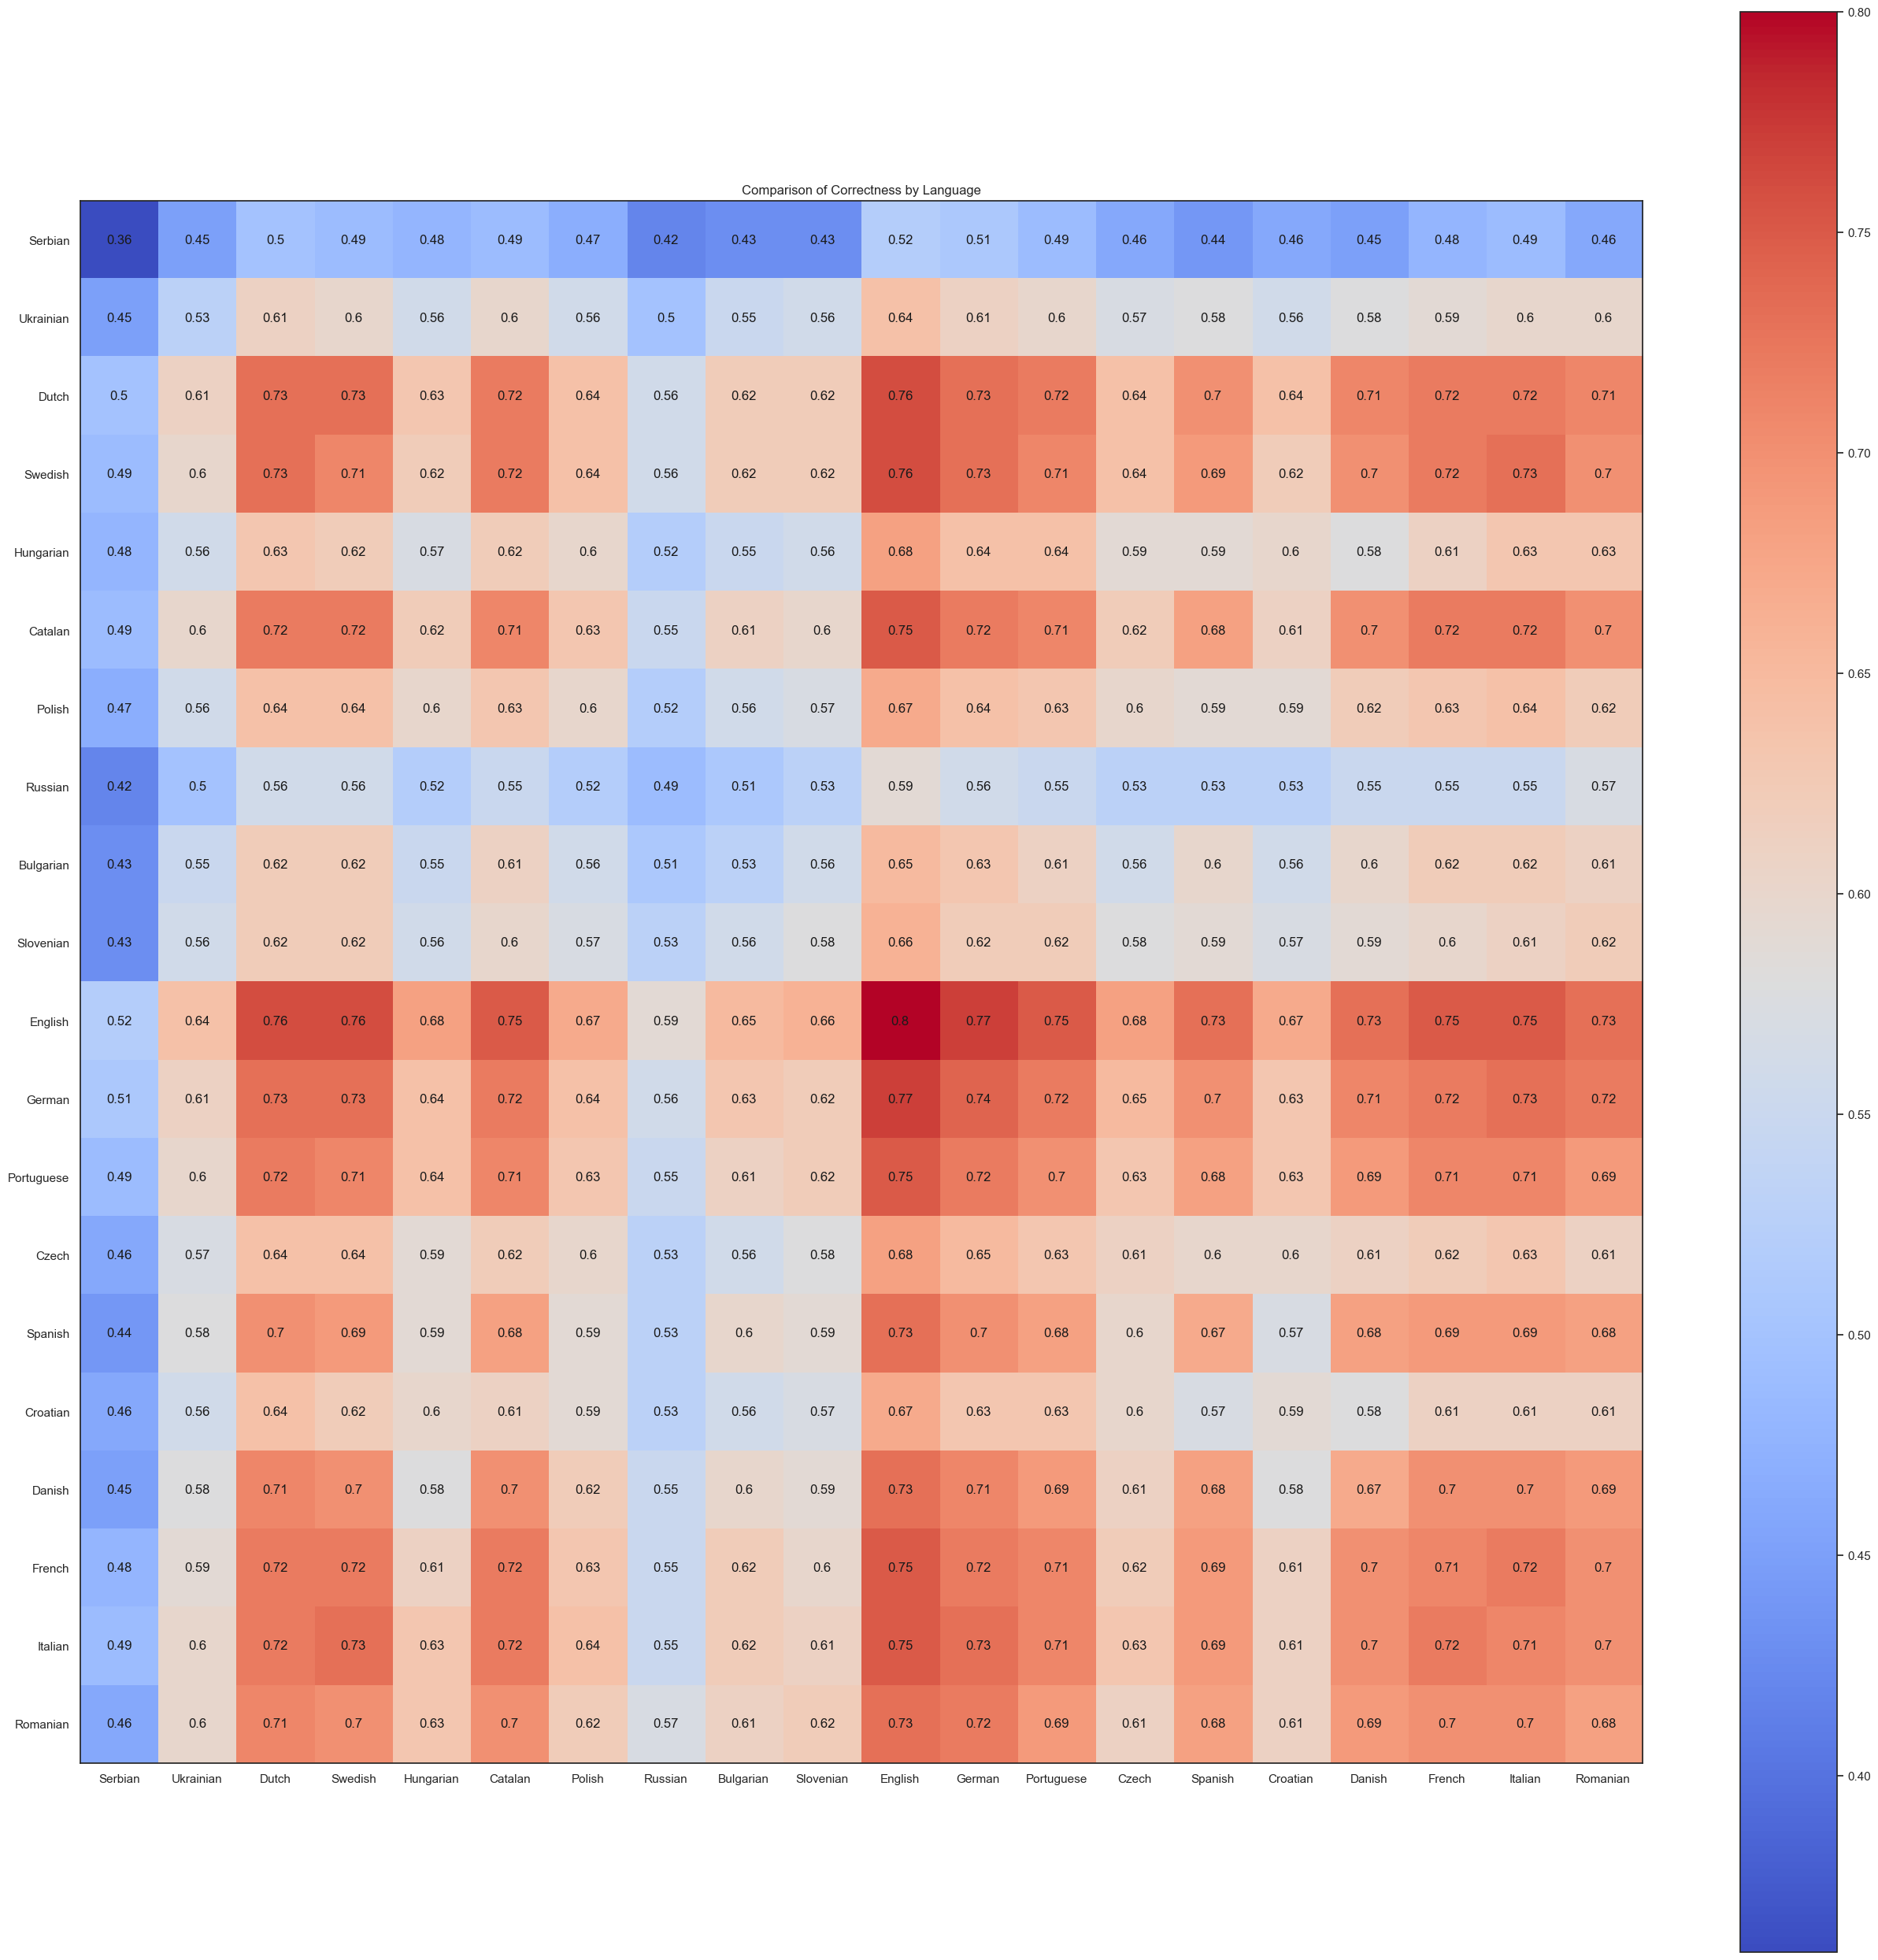

In [449]:
plot_2D(lang_jprob)

##### Conditional probabilities of y-language being correct given x-language is correct

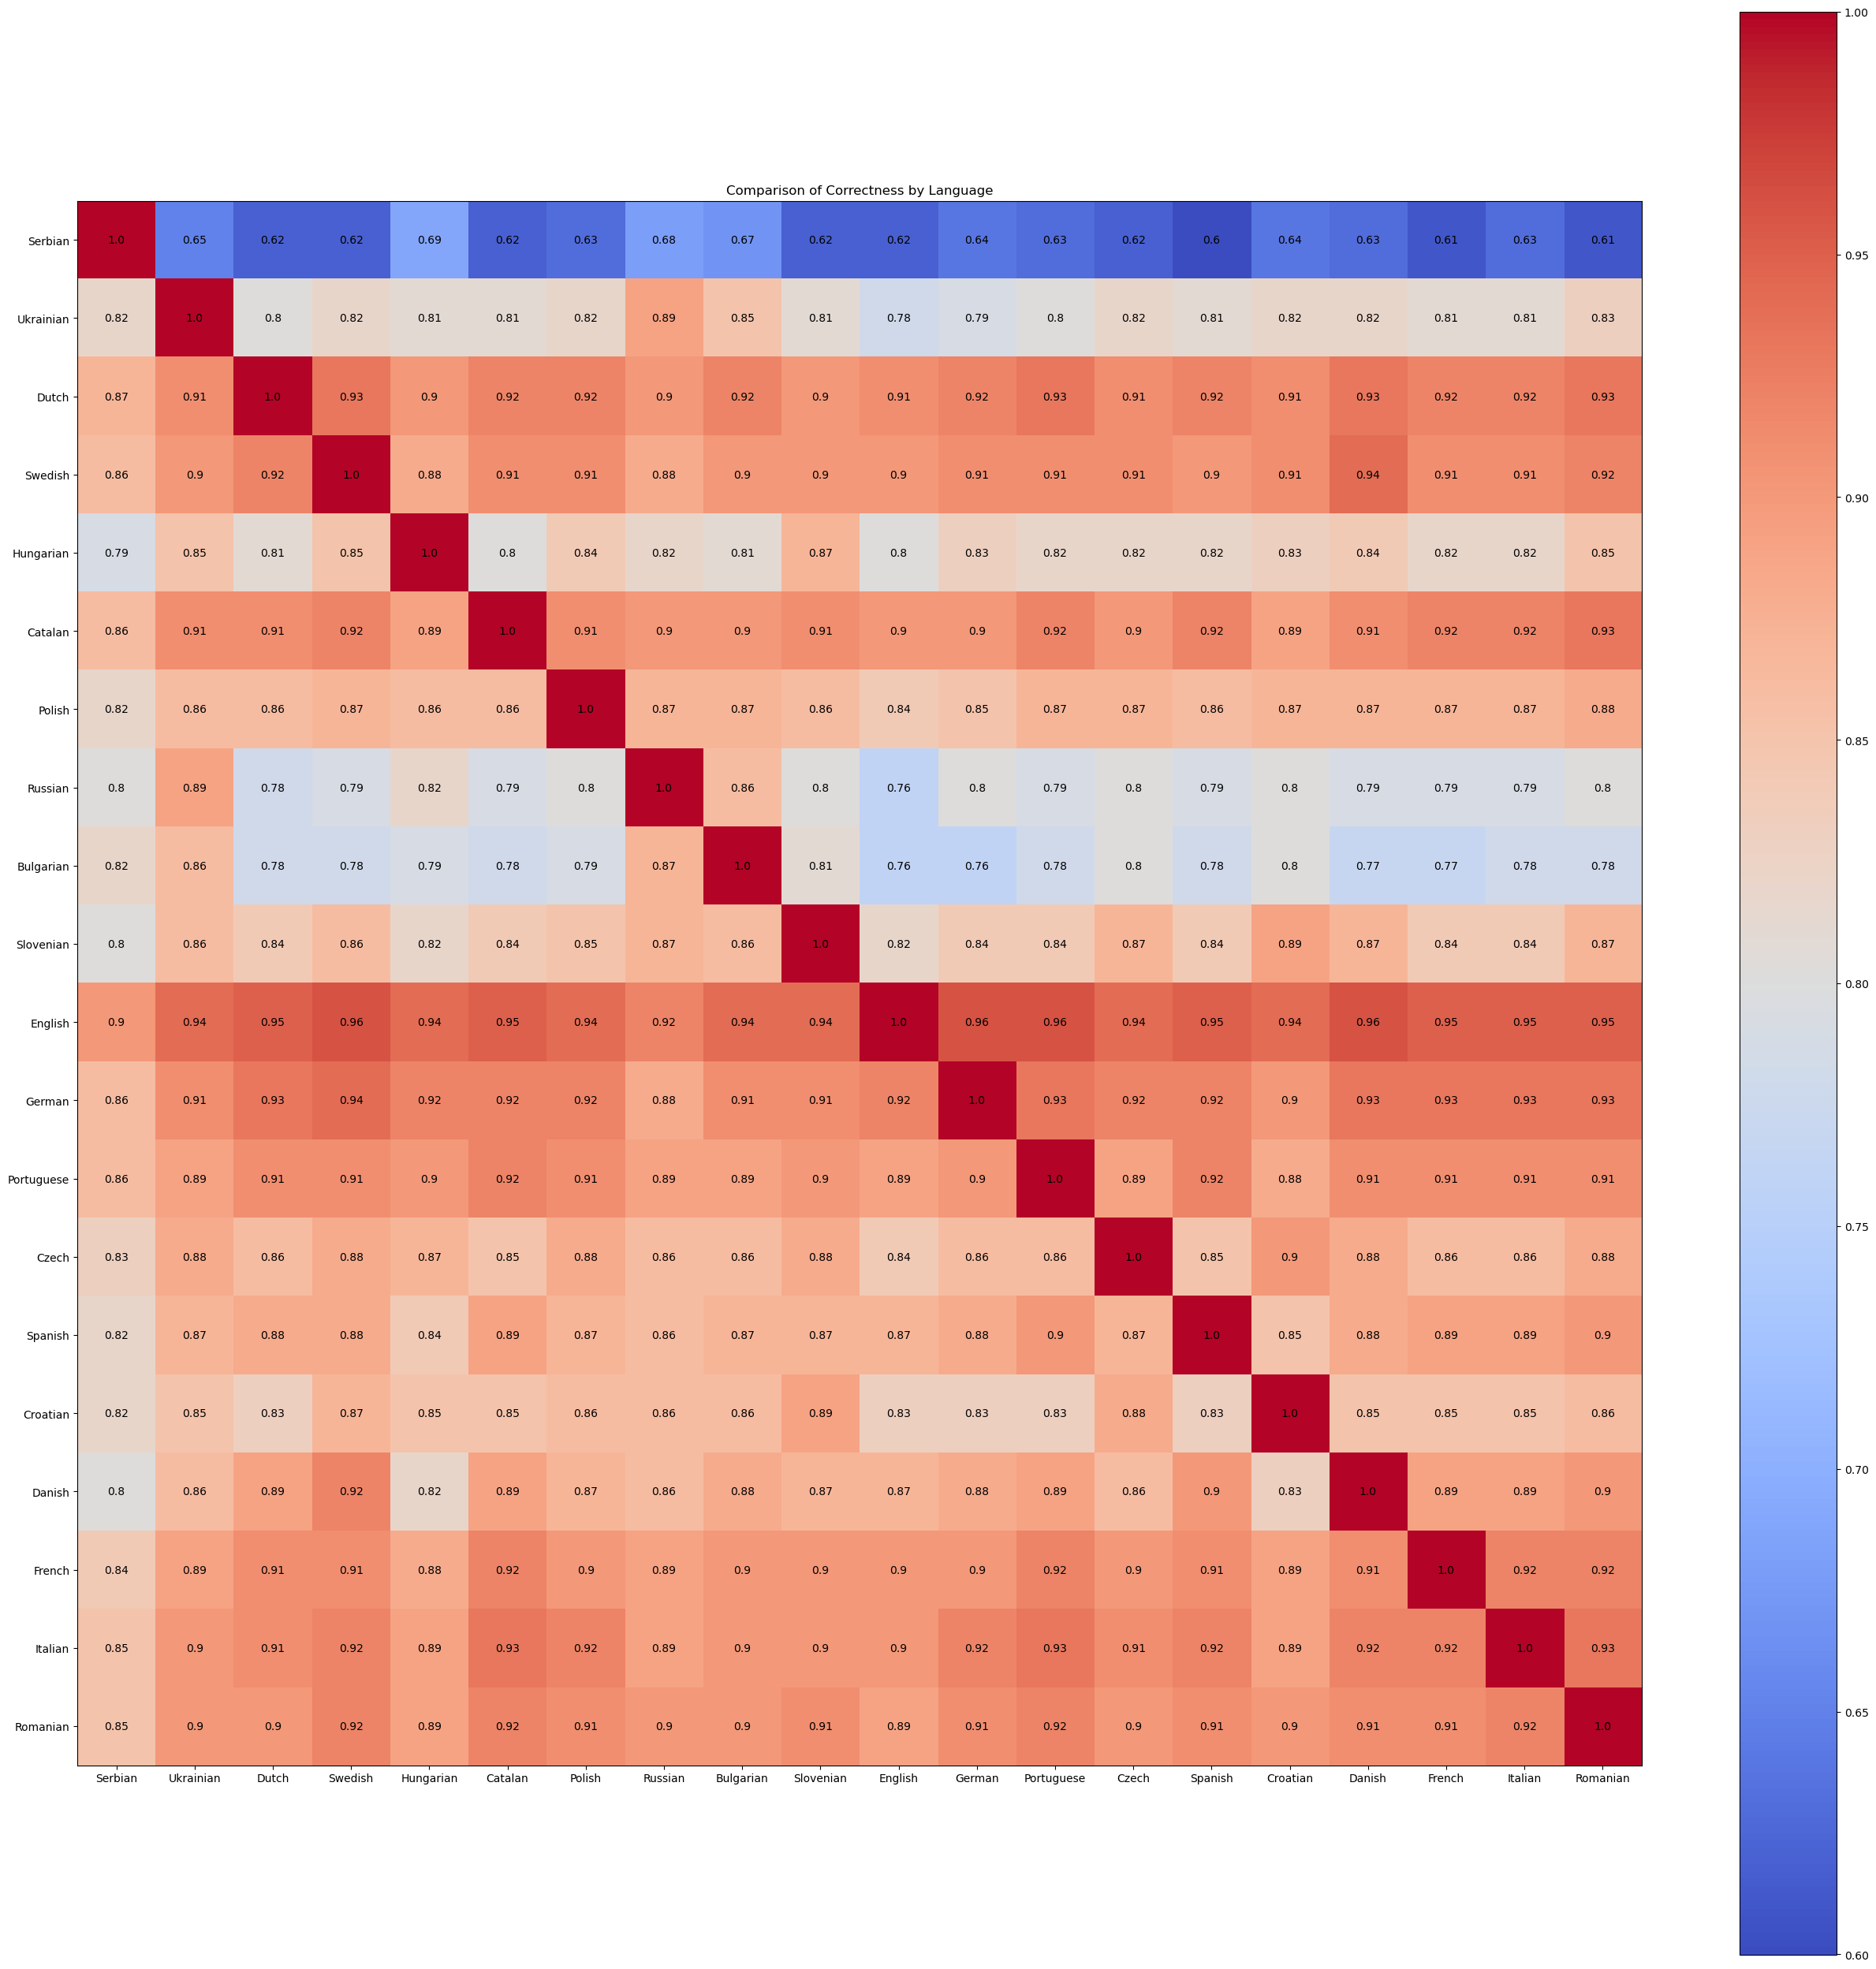

In [383]:
plot_2D(lang_cprob)

In [393]:
# check English only
en_results = {}
for lang in languages:
    en_results.update({("English", lang): lang_cprob("English", lang, results_df)})

for x in sorted(en_results, key=en_results.get, reverse=True):
    print(x, en_results[x])

('English', 'English') 1.0
('English', 'German') 0.964
('English', 'Swedish') 0.962
('English', 'Portuguese') 0.956
('English', 'Danish') 0.956
('English', 'French') 0.954
('English', 'Romanian') 0.954
('English', 'Catalan') 0.953
('English', 'Spanish') 0.953
('English', 'Italian') 0.953
('English', 'Dutch') 0.952
('English', 'Bulgarian') 0.944
('English', 'Polish') 0.943
('English', 'Ukrainian') 0.942
('English', 'Hungarian') 0.942
('English', 'Czech') 0.941
('English', 'Croatian') 0.938
('English', 'Slovenian') 0.936
('English', 'Russian') 0.921
('English', 'Serbian') 0.899


##### Proportion of common facts that are true in left and false in bottom

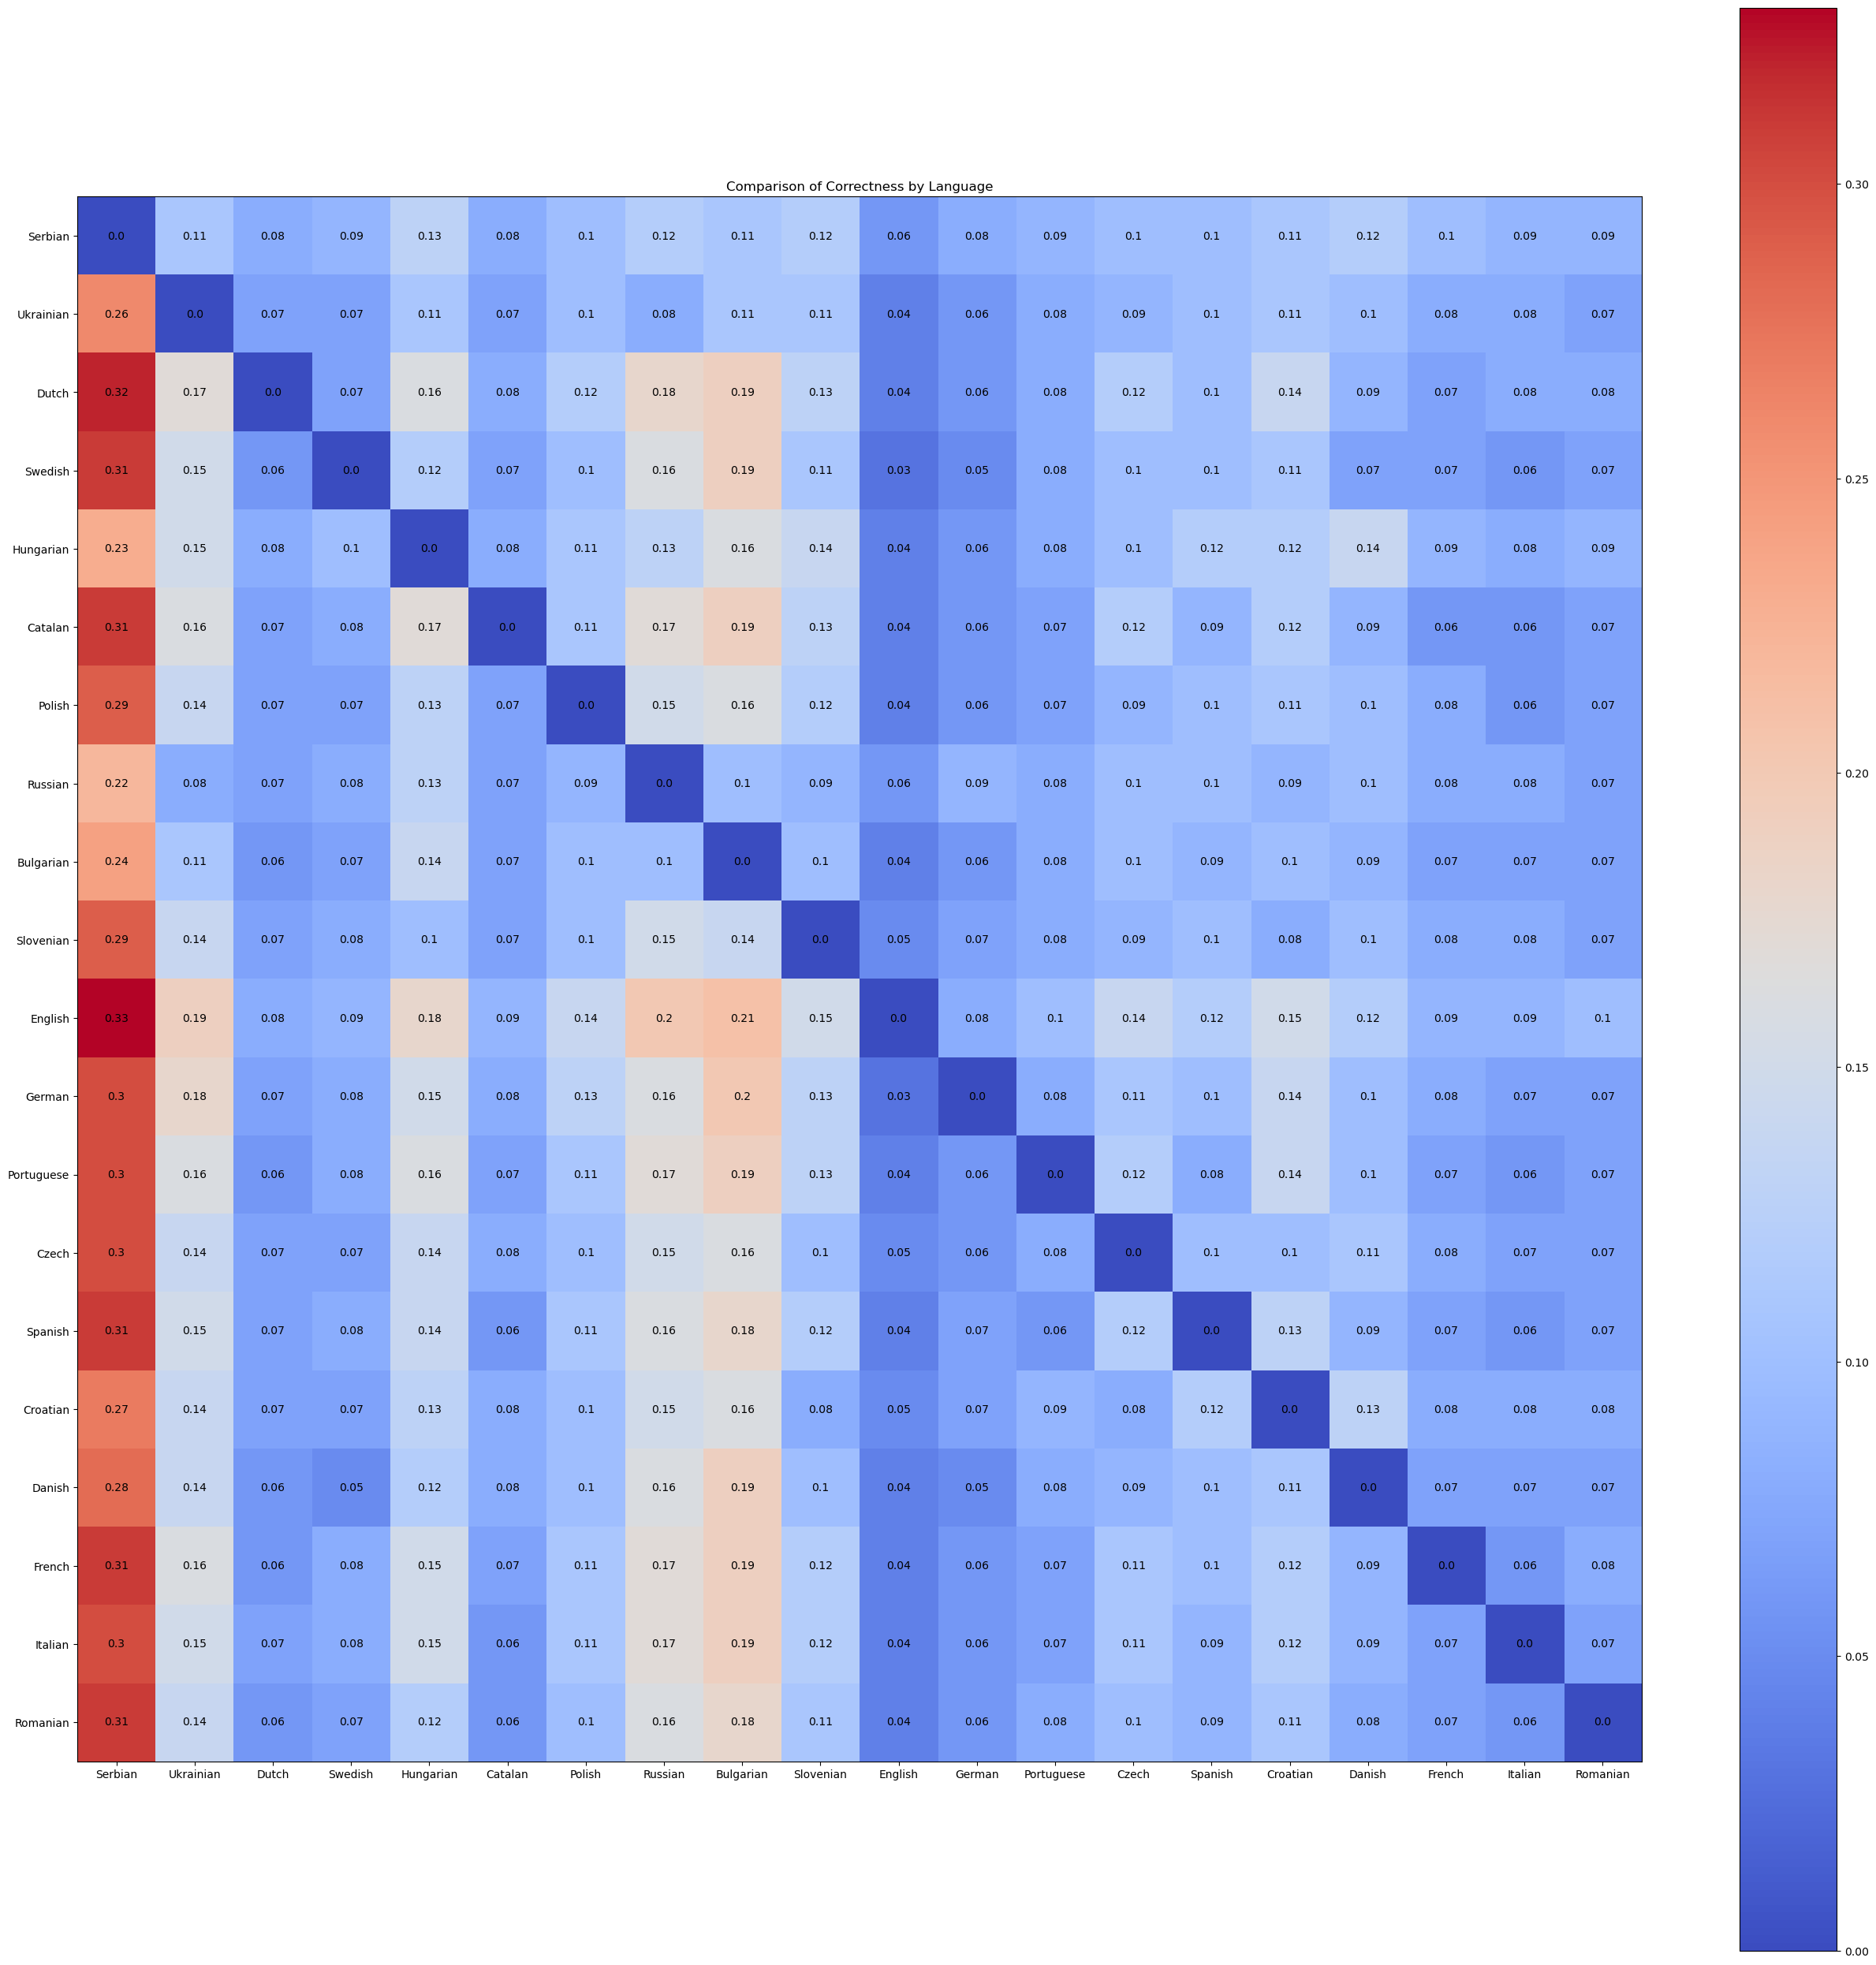

In [385]:
plot_2D(lang_comp)

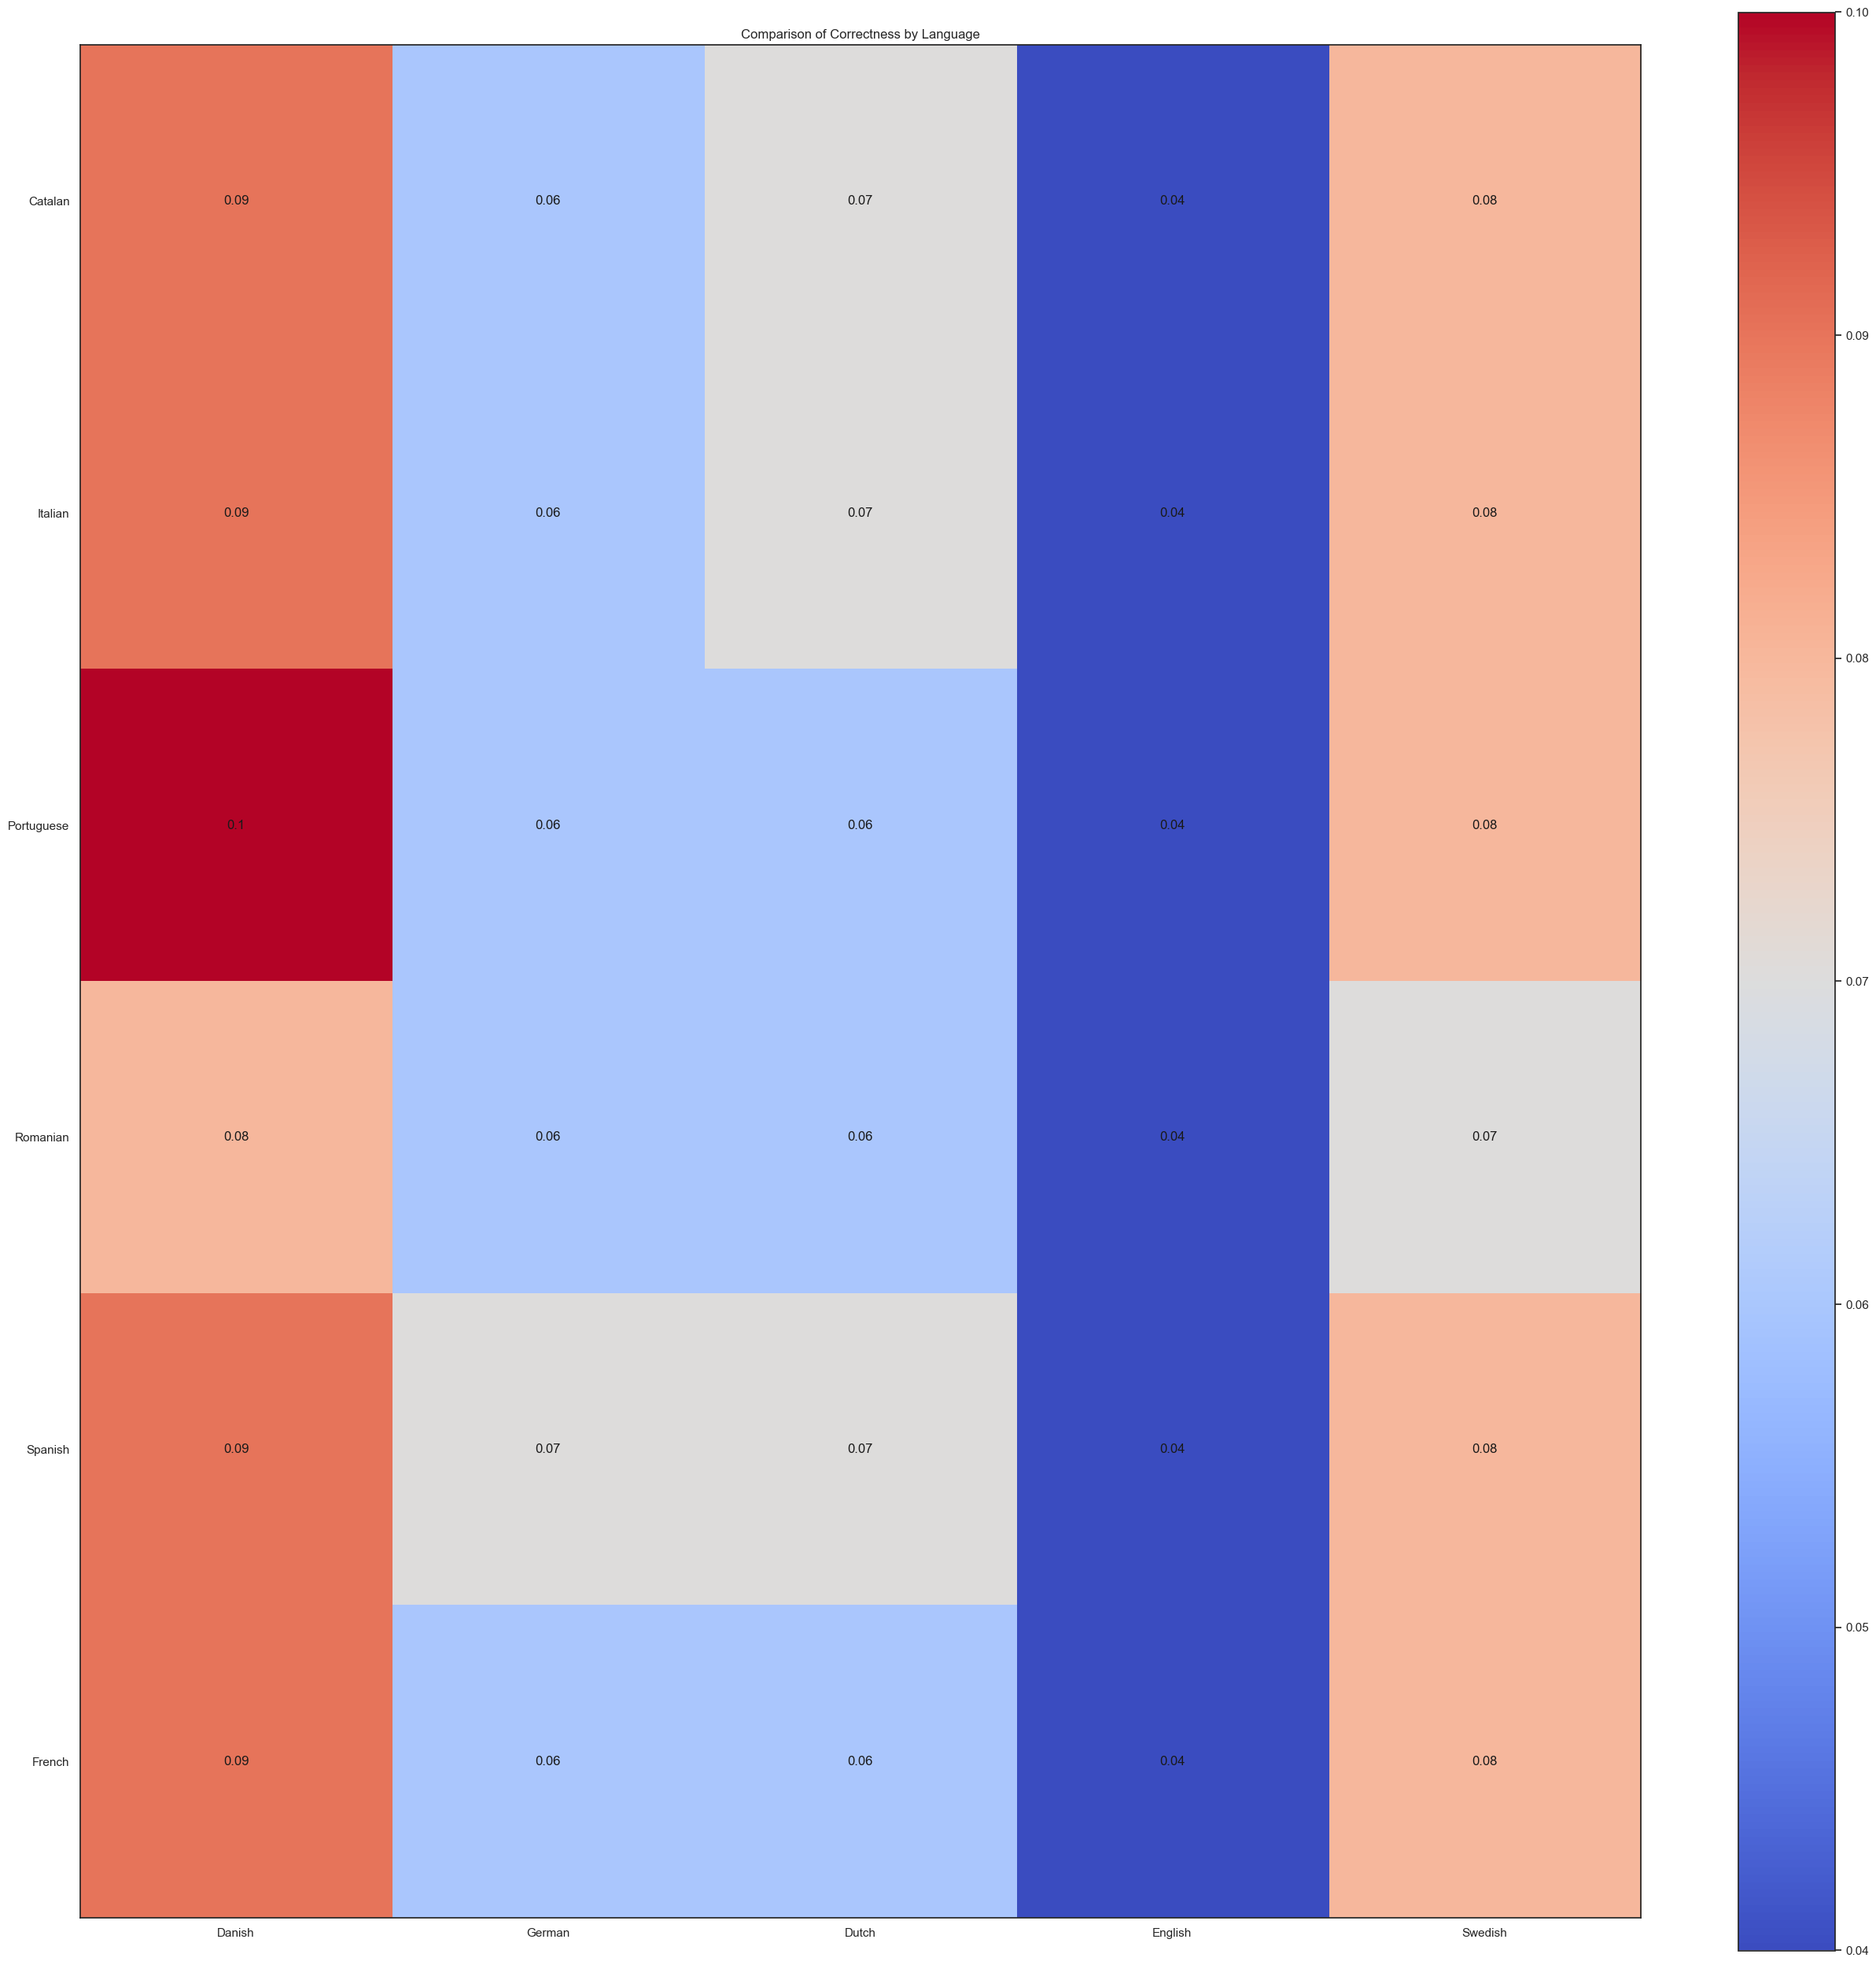

In [450]:
plot_2D(
    lang_comp,
    l1=language_families["Romance"],
    l2=language_families["Germanic"],
    df=results_df,
)

In [410]:
en_results = {}
for lang in languages:
    if lang != "English":
        en_results.update(
            {lang_to_code_dict[lang]: lang_comp("English", lang, results_df)}
        )

for x in sorted(en_results, key=en_results.get, reverse=True):
    print(x, en_results[x])

sr 0.328
bg 0.213
ru 0.199
uk 0.192
hu 0.178
sl 0.151
hr 0.15
pl 0.138
cs 0.135
da 0.116
es 0.115
pt 0.096
ro 0.095
sv 0.093
ca 0.091
fr 0.091
it 0.088
nl 0.081
de 0.077


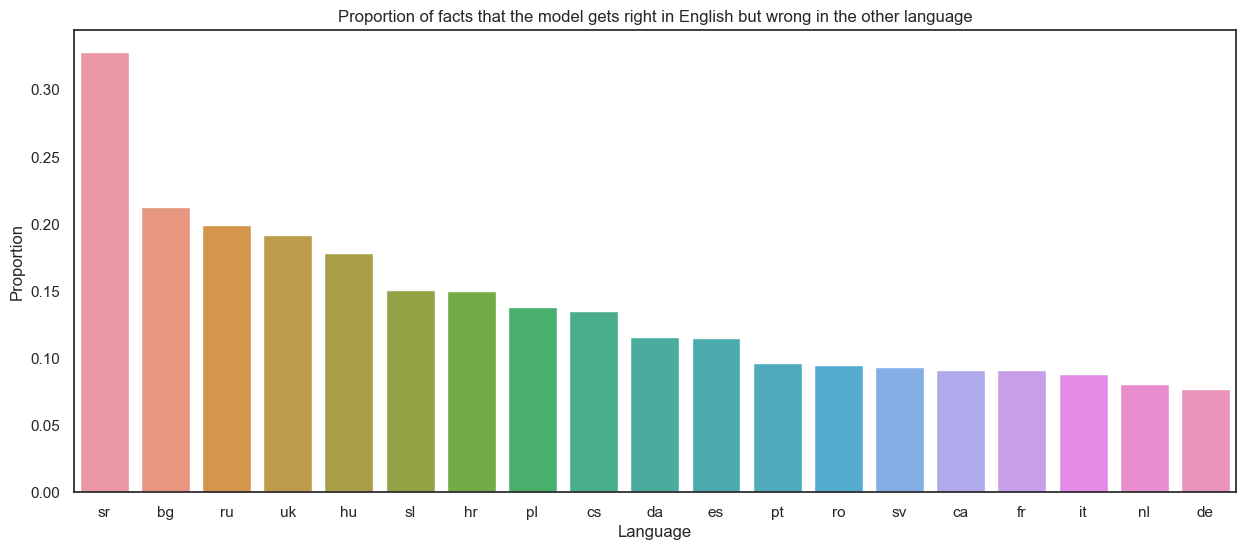

In [413]:
df = pd.DataFrame.from_dict(en_results, orient="index", columns=["proportion"])
df.reset_index(inplace=True)
df.rename(columns={"index": "language"}, inplace=True)
df = df.sort_values(by="proportion", ascending=False)
sns.set(style="white")
plt.figure(figsize=(15, 6))

ax = sns.barplot(x="language", y="proportion", data=df)

ax.set(
    title="Proportion of facts that the model gets right in English but wrong in the other language"
)

ax.set(xlabel="Language", ylabel="Proportion")

# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

##### compare two languages - qualitative

Mainly language, original network, Antarctica, Continent

In [454]:
def compare(l1, l2):  # L1 correct and L2 wrong
    diff_ids = lang_comp(l1, l2, results_df, return_ids=True)[0]
    diff_df = results_df[
        (results_df["language"].isin([l2])) & (results_df["dataset_id"].isin(diff_ids))
    ]
    # print(diff_df["relation_title"].value_counts(normalize=True)[:10])
    # print(diff_df["object_en"].value_counts(normalize=True)[:10])
    # print(diff_df["object"].value_counts(normalize=True)[:10])
    # print(diff_df['subject_en'].value_counts(normalize=True)[:10])

    return diff_df

In [429]:
(compare("English", "German")[["dataset_id", "stem", "true", "false"]][:15])

,dataset_id,stem,true,false
9,rome_8738,Auf Sint Maarten versteht man,Niederländisch,dänisch
63,rome_6811,Die von Manuel Dorrego verwendete Sprache ist,Spanisch,Englisch
64,rome_778,Johan De Farfalla spielt das Instrument,Gitarre,Klavier
83,rome_19127,"Diego Maradona, der",Mittelfeldspieler,Krug
92,rome_3332,Die Sprache von By the Light of a Star war,Spanisch,Französisch
99,calinet_694,Malegapuru William Makgoba stammte ursprünglic...,Sekhukhune,Distrikt Kapchorwa <br> La Pobla de Segur <br>...
112,rome_13575,Tom Eckersleys Leben endete in <br> Tom Eckers...,London,Arktis
119,rome_12168,Executive Committee Range befindet sich in der...,Antarktis,Europa
142,rome_10461,Fritz Reiner arbeitete in der Stadt <br> Fritz...,Dresden,London
149,calinet_1542,Judith Butlers Expertise ist <br> Judith Butle...,queer,Tierrechte <br> algebraischer Geometer <br> Za...


In [469]:
en_ro = []
for l2 in language_families["Germanic"]:
    en_ro.append(compare("English", l2))

en_ro = pd.concat(en_ro)
print(en_ro["relation_title"].value_counts(normalize=True)[:10])
print(en_ro["object_en"].value_counts(normalize=True)[:10])
print(en_ro["subject_en"].value_counts(normalize=True)[:10])

field of work        0.078298
original network     0.068912
occupation           0.061841
continent            0.060170
place of death       0.057341
original language    0.056698
languages spoken     0.054513
position held        0.051299
genre                0.046542
official language    0.044099
Name: relation_title, dtype: float64
Antarctica    0.050270
French        0.034070
Russian       0.026356
CBS           0.023271
English       0.020699
bishop        0.020314
Italian       0.018771
Dutch         0.014914
violin        0.013757
jazz          0.013757
Name: object_en, dtype: float64
They               0.001157
Wales              0.000900
Switzerland        0.000900
European Union     0.000900
Quebec             0.000900
Life Unexpected    0.000771
Fritz Reiner       0.000771
Lamont Dozier      0.000771
Anaxagoras         0.000771
The Rasmus         0.000643
Name: subject_en, dtype: float64


##### Language families vs English

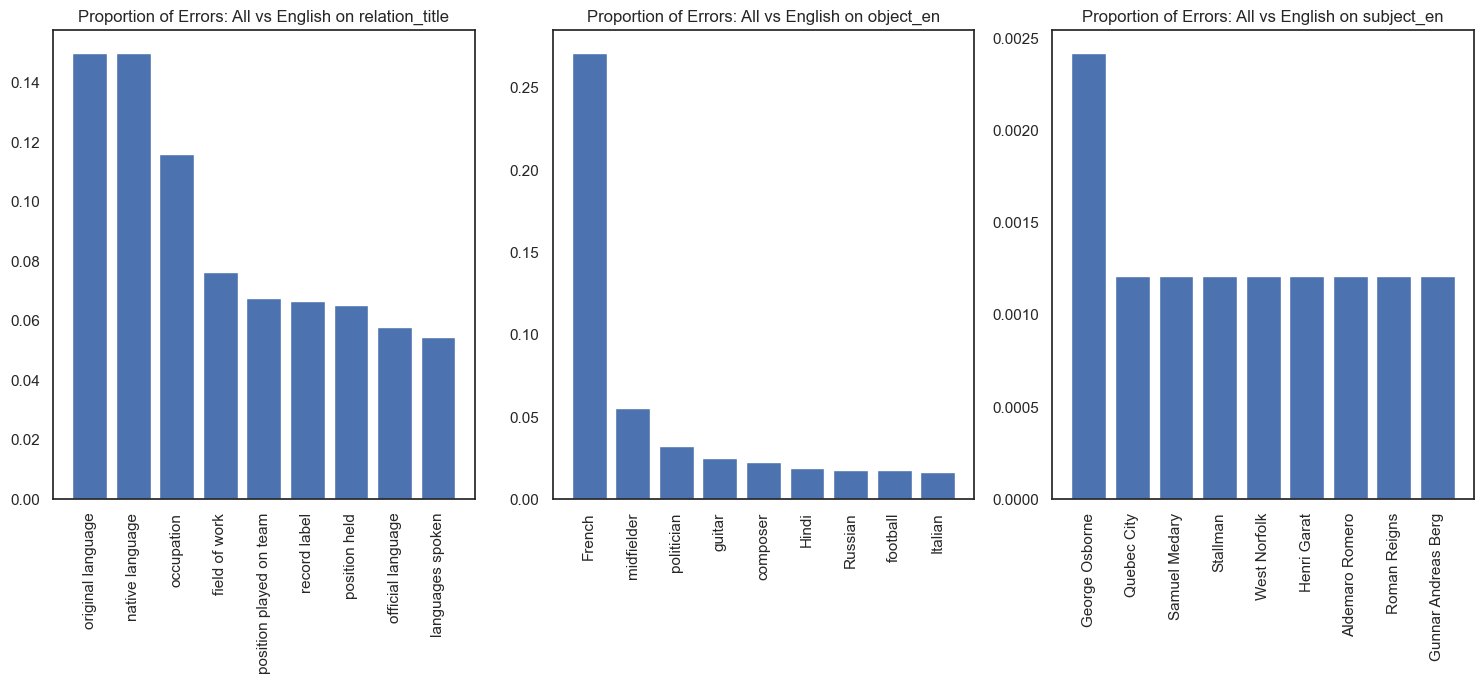

In [511]:
fig, axs = plt.subplots(1, 3, figsize=(15, 7))
axs = axs.ravel()


for i, feature in enumerate(["relation_title", "object_en", "subject_en"]):
    results = []
    for lang in languages:
        results.append(compare("English", lang))
    df = pd.concat(results)
    top10 = df[feature].value_counts(normalize=True)[:9]

    axs[i].bar(top10.index, top10.values)
    axs[i].set_title("Proportion of Errors: All vs English on " + feature)
    axs[i].tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.show()

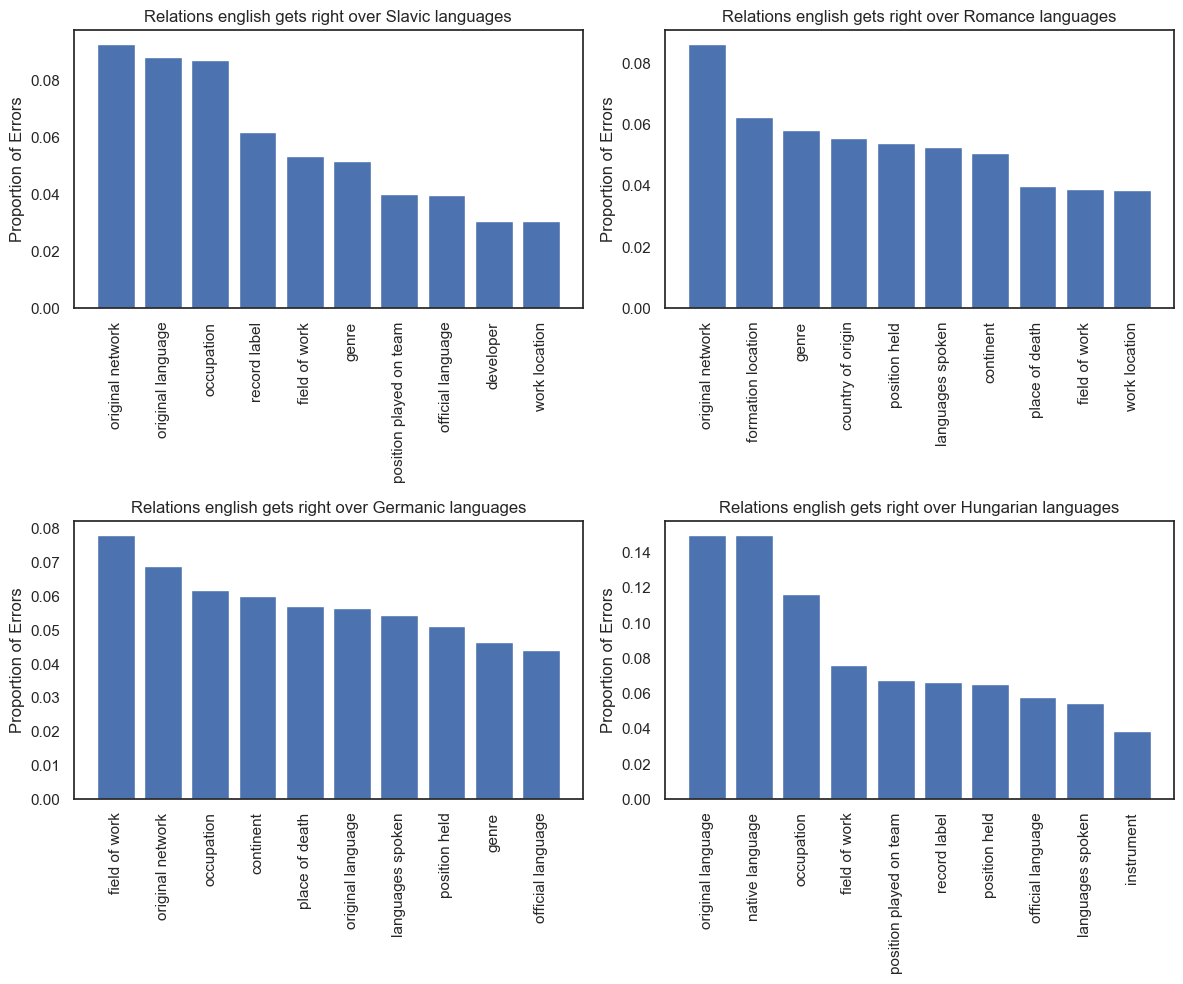

In [513]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()


for i, (family, languages) in enumerate(language_families.items()):
    results = []
    for lang in languages:
        results.append(compare("English", lang))
    df = pd.concat(results)
    top10 = df["relation_title"].value_counts(normalize=True)[:10]

    axs[i].bar(top10.index, top10.values)
    axs[i].set_title("Relations english gets right over " + family + " languages")
    axs[i].set_ylabel("Proportion of Errors")
    axs[i].tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.show()

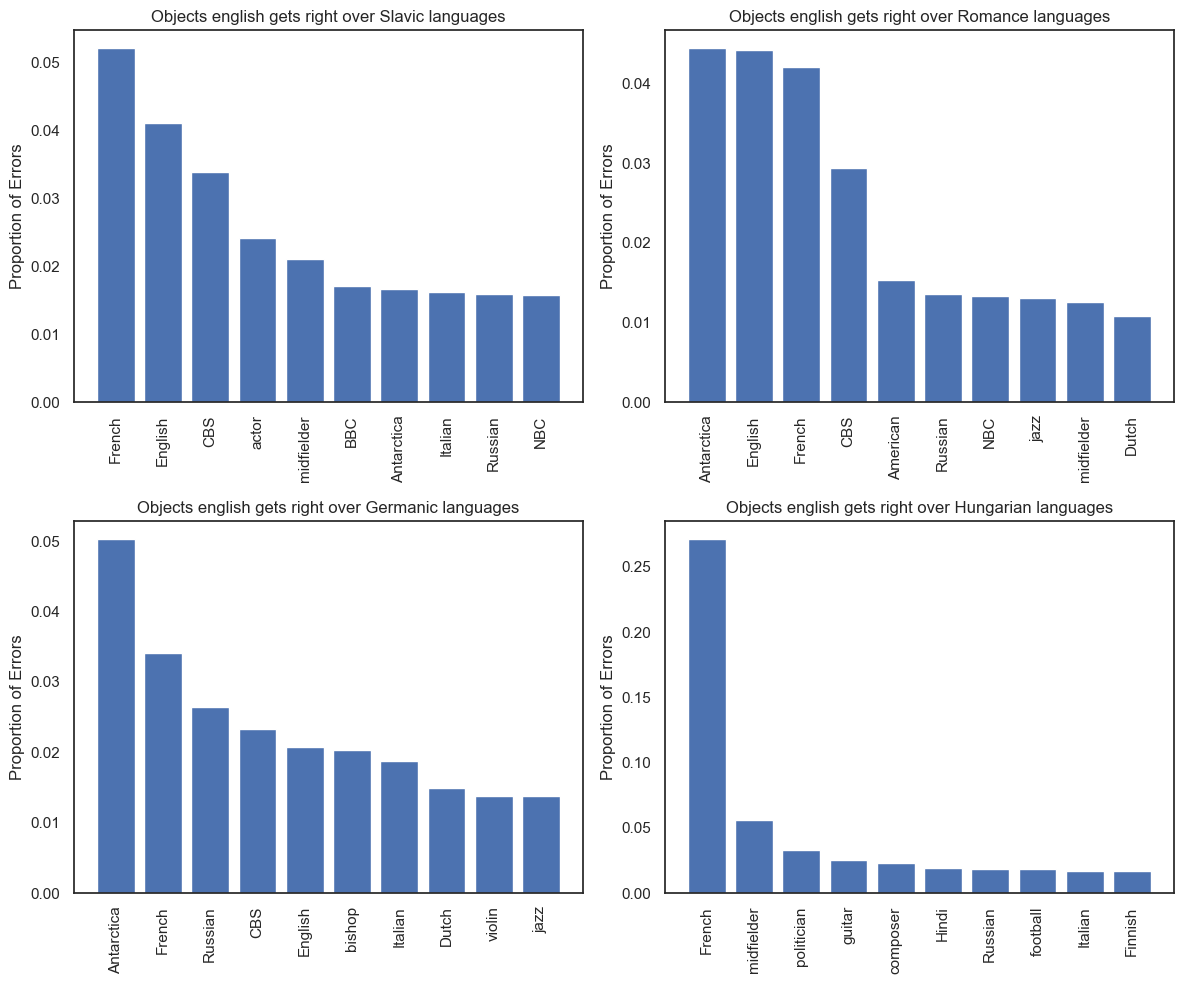

In [514]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()


for i, (family, languages) in enumerate(language_families.items()):
    results = []
    for lang in languages:
        results.append(compare("English", lang))
    df = pd.concat(results)
    top10 = df["object_en"].value_counts(normalize=True)[:10]

    axs[i].bar(top10.index, top10.values)
    axs[i].set_title("Objects english gets right over " + family + " languages")
    axs[i].set_ylabel("Proportion of Errors")
    axs[i].tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.show()

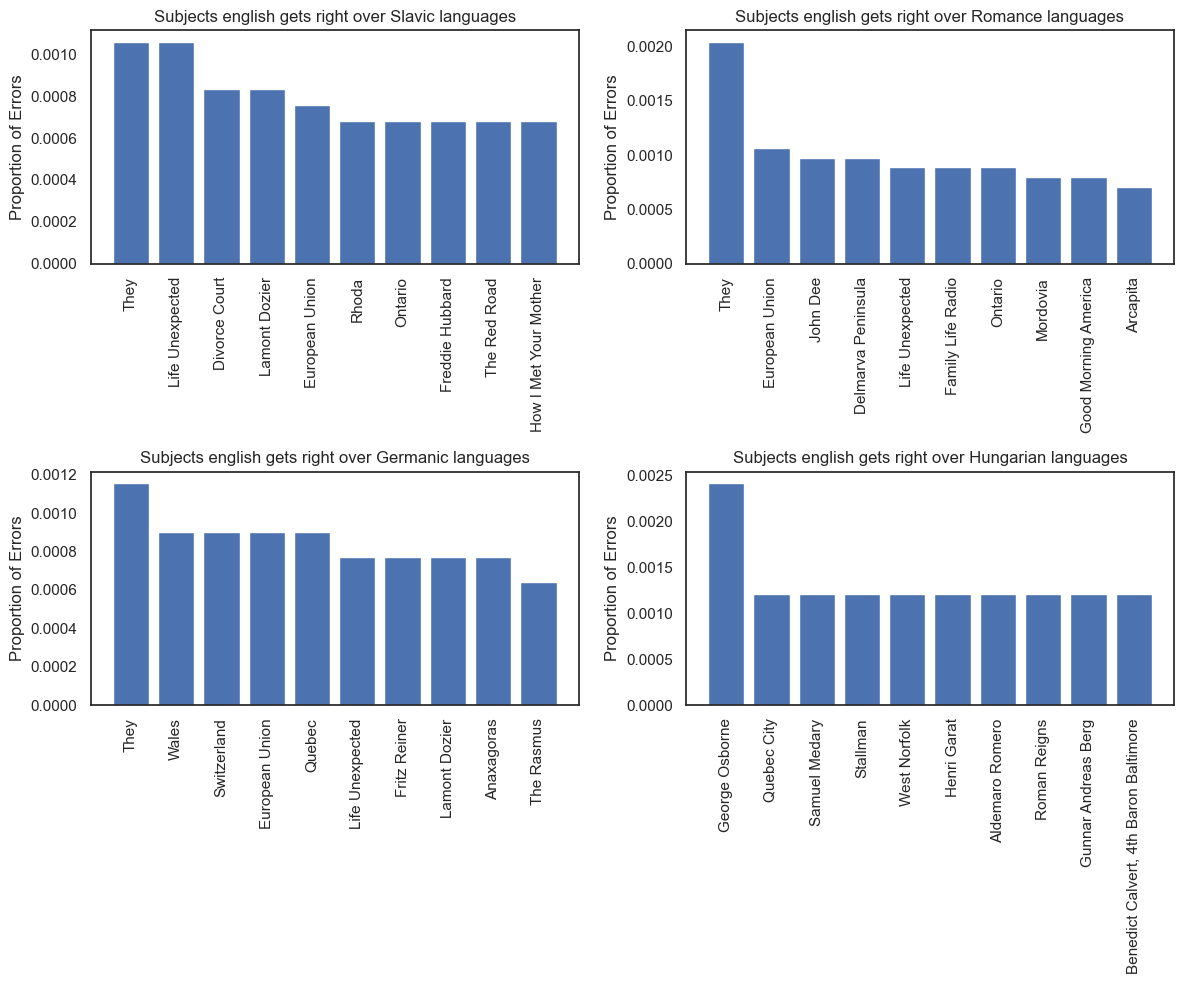

In [515]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()


for i, (family, languages) in enumerate(language_families.items()):
    results = []
    for lang in languages:
        results.append(compare("English", lang))
    df = pd.concat(results)
    top10 = df["subject_en"].value_counts(normalize=True)[:10]

    axs[i].bar(top10.index, top10.values)
    axs[i].set_title("Subjects english gets right over " + family + " languages")
    axs[i].set_ylabel("Proportion of Errors")
    axs[i].tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.show()